In [1]:
# pip install xgboost
# %pip install graphviz

In [7]:
from xgboost import XGBRegressor
import pandas as pd 
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import joblib
from xgboost import plot_tree
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Importing excel sheets as dfs, should both have samples in the same order
predictors_df = pd.read_excel('../Predictors_Cleaned.xlsx', 0)
    # Rows are samples, columns are predictors
outcomes_df = pd.read_excel('../Outcomes_Cleaned.xlsx', 0)
    # Rows are samples, columns are mechanisms

# Dropping unnecessary metadata
X = predictors_df.drop('SAMPLE NAME', axis=1)
Y = outcomes_df.drop('MECHANISM', axis=1) # Full DF must iterate through
feature_names = X.columns
gene_names = Y.columns

# List of columns for iterating
columns = list(Y)


# print(predictors_df) # 211 x 33
# print(outcomes_df) # 211 x 41

In [3]:
r2_list = []

for i in columns:
    
    # resetting the r2 and best model value for each column
    r2 = 0
    best_model = XGBRegressor()
    
    # Iterate through common proportions of test/train data
    for j in [0.2, 0.4, 0.6, 0.8]:

        # Split Data
        x_train, x_test, y_train, y_test = train_test_split(X, Y[i], test_size=j) 

        # Iterate through common n_estimators
        for k in [100, 500, 1000]:

            # Create model
            xg = XGBRegressor(n_estimators=k) 
            xg = xg.fit(x_train, y_train)

            # Find model r squared
            predictions = xg.predict(x_test)
            new_r2 = abs(r2_score(y_test, predictions)) # using absolute value for comparision

            # Compare model, if model r2 is over 1 then its very bad fit so we don't save it
            if new_r2 <= 1:
                if new_r2 > r2:
                    r2 = new_r2
                    # Saving the better model
                    best_model = xg
                    # Saving best model params for visualization
                    best_x_test = x_test
                    best_y_test = y_test
    
    # Storing highest r2
    r2_list.append(r2)
    # Printing r2
    print(f"{i} r2: {r2}")
    
    if r2 != 0: # if a best model exists
        # Finally dumping the best model for the class
        joblib.dump(best_model, f"Models/xgb_{i}.joblib")
    
        # Visualizing Tree
        plt.figure()  
        plot_tree(best_model) 
        plt.gcf().set_size_inches(60, 40)
        plt.savefig(f'Trees/{i}_tree.png')
        plt.close()
    
        # Visualizing feature importance
        perm_importance = permutation_importance(best_model, best_x_test, best_y_test)
        sorted_idx = perm_importance.importances_mean.argsort()
        plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
        plt.gcf().set_size_inches(10, 7)
        plt.xlabel(f"{i} Permutation Importance")
        plt.savefig(f'Features/{i}_features.png')
        plt.close()

Lipopeptides r2: 0.611343264579773
Arsenic_resistance r2: 0.5747275352478027
Copper_resistance r2: 0.41081666946411133
Rifampin r2: 0.4630706310272217
Trimethoprim r2: 0.8365345001220703
Tellurim_resistance r2: 0.41763317584991455
Zinc_resistance r2: 0.3321208953857422
Peroxide_resistance r2: 0.9034314155578613
Multi-drug_resistance r2: 0.46544349193573
Acid_resistance r2: 0.2872227430343628
Phenolic_compound_resistance r2: 0.3500407934188843
Mupirocin r2: 0.007936716079711914
Nucleosides r2: 0.43216514587402344
Aldehyde_resistance r2: 0.48887860774993896
Paraquat_resistance r2: 0.9431953430175781
Betalactams r2: 0.2137836217880249
Tetracyclines r2: 0.6990499496459961
Nickel_resistance r2: 0.4435924291610718
Multibiocide_resistance r2: 0.2312525510787964
Aminoglycoside r2: 0.4483898878097534
MLS r2: 0.2917633056640625
Fluoroquinolones r2: 0.4933387041091919
Fosfomycin r2: 0.6956669092178345
Phenicol_resistance r2: 0.4181954860687256
Drug_and_biocide_resistance r2: 0.6184427738189697
Mu

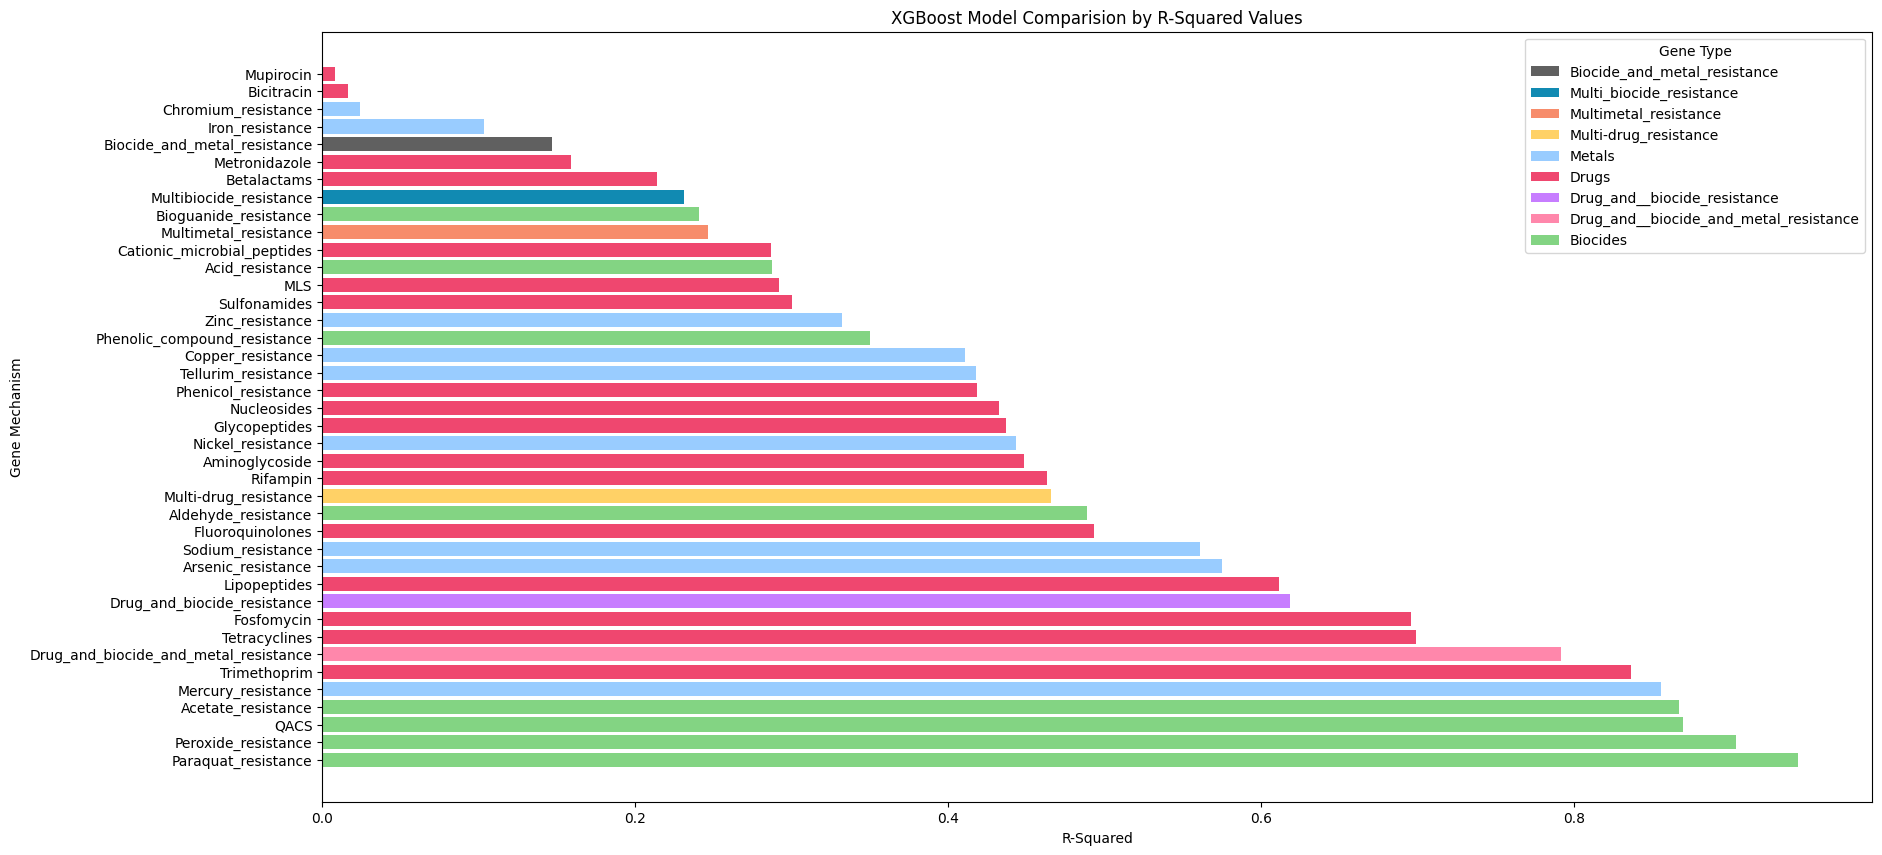

In [ ]:
# Plotting an overall comparision of different models and their r2 scores
# Order and compare the accuracy of models depending on drug/metal/biociode/multicompound types etc
import numpy as np

fig, ax = plt.subplots(figsize=(20,10))

# Sorting r2 values for visualization
sorted_idx = np.argsort(r2_list)
r2_array = np.array(r2_list)

# Sorting colors for visualization
bar_labels = ['Drugs', 'Metals', '_Metals', '_Drugs', '_Drugs', '_Metals', '_Metals', 'Biocides', 'Multi-drug_resistance', '_Biocides', '_Biocides', '_Drugs', '_Drugs', '_Biocides', '_Biocides', '_Drugs', '_Drugs', '_Metals', 'Multi_biocide_resistance', '_Drugs', '_Drugs', '_Drugs', '_Drugs', '_Drugs', 'Drug_and__biocide_resistance', 'Multimetal_resistance', '_Metals', '_Drugs', '_Drugs', 'Drug_and__biocide_and_metal_resistance', '_Drugs', 'Biocide_and_metal_resistance', '_Metals', '_Biocides', '_Drugs', '_Biocides', '_Drugs', '_Metals', '_Metals', '_Biocides']

drug_color = '#ef476f'
metal_color = '#99ccff'
biocide_color = '#83d483'
multi_drug_color = '#ffd166'
multi_metal_color = '#f78c6b'
multi_biocide_color = '#118ab2'
drug_biocide_color = '#c77dff'
drug_biocide_metal_color = "#f695ff"
metal_biocide_color = "#2C2C2C"

bar_colors = [f'{drug_color}', f'{metal_color}', f'{metal_color}', f'{drug_color}', f'{drug_color}', f'{metal_color}', f'{metal_color}', f'{biocide_color}', f'{multi_drug_color}', f'{biocide_color}', f'{biocide_color}', f'{drug_color}', f'{drug_color}', f'{biocide_color}', f'{biocide_color}', f'{drug_color}', f'{drug_color}', f'{metal_color}', f'{multi_biocide_color}', f'{drug_color}', f'{drug_color}', f'{drug_color}', f'{drug_color}', f'{drug_color}', f'{drug_biocide_color}', f'{multi_metal_color}', f'{metal_color}', f'{drug_color}', f'{drug_color}', f'{drug_biocide_metal_color}', f'{drug_color}', f'{metal_biocide_color}', f'{metal_color}', f'{biocide_color}', f'{drug_color}', f'{biocide_color}', f'{drug_color}', f'{metal_color}', f'{metal_color}', f'{biocide_color}']
# [f'tab:{drug_color}', f'tab:{metal_color}', f'tab:{metal_color}', f'tab:{drug_color}', f'tab:{drug_color}', f'tab:{metal_color}', f'tab:{metal_color}', f'tab:{biocide_color}', f'tab:{multi_drug_color}', f'tab:{biocide_color}', f'tab:{biocide_color}', f'tab:{drug_color}', f'tab:{drug_color}', f'tab:{biocide_color}', f'tab:{biocide_color}', f'tab:{drug_color}', f'tab:{drug_color}', f'tab:{metal_color}', f'tab:{multi_biocide_color}', f'tab:{drug_color}', f'tab:{drug_color}', f'tab:{drug_color}', f'tab:{drug_color}', f'tab:{drug_color}', f'tab:{drug_biocide_color}', f'tab:{multi_metal_color}', f'tab:{metal_color}', f'tab:{drug_color}', f'tab:{drug_color}', f'tab:{drug_biocide_metal_color}', f'tab:{drug_color}', f'tab:{metal_biocide_color}', f'tab:{metal_color}', f'tab:{biocide_color}', f'tab:{drug_color}', f'tab:{biocide_color}', f'tab:{drug_color}', f'tab:{metal_color}', f'tab:{metal_color}', f'tab:{biocide_color}']

# Plotting graph
ax.barh(gene_names[sorted_idx], r2_array[sorted_idx], align='center', label=np.array(bar_labels)[sorted_idx], color=np.array(bar_colors)[sorted_idx])
# ax.barh(np.arange(len(columns)), r2_list, align='center') # old code
ax.set_yticks(np.arange(len(columns)), labels=gene_names[sorted_idx])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('R-Squared')
ax.set_ylabel('Gene Mechanism')
ax.set_title('XGBoost Model Comparision by R-Squared Values')
ax.legend(title='Gene Type')

plt.savefig(f'xgb_r2_graph.png')
plt.show()